# **Proyecto: Análisis y Predicción de la Calidad del Agua en la India**

**Autor:** Natalia Echeverry Salcedo  
**Fecha de inicio:** 28 de julio de 2025  
**Fecha actual:** 17 de octubre de 2025  

---

## **Problemática**

El tratamiento del agua constituye un proceso esencial para garantizar su pureza y calidad, ya que de ello depende la salud pública y el bienestar de la población. En numerosos países, entre ellos la India, la contaminación del agua representa un desafío crítico debido a la presencia de residuos industriales, agrícolas y domésticos.  
Frente a este panorama, el uso de herramientas de *procesamiento de datos en alto volumen (Big Data Processing)* permite abordar el problema desde una perspectiva analítica, aprovechando grandes conjuntos de datos para detectar patrones, predecir niveles de contaminación y proponer estrategias de mejora en la gestión de recursos hídricos.  

El presente proyecto busca aplicar los principios del **Procesamiento Analítico de Volúmenes de Datos (PAVD)** en la evaluación de la calidad del agua en la India, empleando técnicas de análisis de datos masivos y aprendizaje automático (Machine Learning) para el diagnóstico y predicción de su pureza.

---

## **Objetivo General**

Implementar modelos predictivos mediante la biblioteca de aprendizaje automático **MLlib de PySpark**, con el propósito de explorar y aplicar técnicas de inteligencia artificial en entornos de **procesamiento de datos a gran escala**, orientadas al análisis y predicción de la calidad del agua en la India.

---

## **Metodología**

1. **Importación de los datos:**  
   Carga de los conjuntos de datos provenientes de *IDRIVE*, en diferentes formatos compatibles con PySpark (CSV, JSON, Parquet, entre otros).

2. **Preprocesamiento y limpieza:**  
   Identificación y tratamiento de valores nulos, transformación de tipos de datos, análisis exploratorio (EDA) y cálculo de medidas estadísticas descriptivas.

3. **Entrenamiento de modelos:**  
   Implementación de modelos de aprendizaje supervisado utilizando **Regresión Lineal (MLlib)** y técnicas basadas en **tensores con Keras**, orientadas a la predicción de la calidad del agua.

4. **Evaluación de modelos:**  
   Análisis de desempeño mediante métricas como **precisión (Precision)**, **exactitud (Accuracy)**, **sensibilidad (Recall)** y **puntaje F1 (F1-Score)**, entre otras.

5. **Referencias técnicas:**  
   Los estándares de calidad del agua considerados se basan en la referencia científica disponible en:  
   🔗 [IntechOpen – Water Quality Parameters](https://www.intechopen.com/chapters/69568)

---



## **1. Importación de bibliotecas**

In [ ]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# Módulos del sistema para manejo de rutas y paquetes.
import os
import sys
sys.path.append('/usr/lib/python3/dist-packages/')

# Librerías para análisis y visualización de datos.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *

# Inicialización del entorno Spark.
import findspark
findspark.init()

# Funciones y estructuras principales de PySpark.
import pyspark.sql.functions as F
from pyspark.sql.functions import input_file_name, mean, col, split, regexp_extract, when, lit, isnan, count
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *

In [ ]:
# Se define la configuración básica de la aplicación en Spark.
configura = SparkConf()
configura.setAppName("Prueba_Water01")  # Nombre asignado a la sesión de Spark.

# Creación de la sesión principal de Spark.
# SparkSession es el punto de entrada para trabajar con DataFrames distribuidos.
sparkS = SparkSession.builder.config(conf=configura).getOrCreate()

# Inicializa el contexto SQL asociado a la sesión.
SQLContext(sparkContext=sparkS.sparkContext, sparkSession=sparkS)

# Obtiene o crea el contexto principal de Spark.
sparkContextoS = sparkS.sparkContext.getOrCreate()

# Confirmación en consola de la sesión activa.
print("Sesión creada: HPC004")
sparkS  # Muestra información de la sesión activa.

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/16 21:31:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Sesión creada: HPC004


## **2. Carga de Datos desde el HADOOP HDFS**

In [ ]:
#Acceso a Hadoop HDFS

!/mnt/sda1/Cluster/Hadoop/bin/hadoop fs -ls /csv

/bin/bash: line 1: /mnt/sda1/Cluster/Hadoop/bin/hadoop: No such file or directory


In [ ]:
df00 = sparkS.read.format("csv").option("header", "true").load("hdfs://10.195.34.34:9000/csv/waterquality.csv")
df00.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|         735|3.4|                  2|             3|            73|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|  6|  8|         270|3.1|                  2|            72|           182|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|         355|4.2|                  9|            59|           133|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|         371|5.6|               3.55|            90|           283|
|        2183|GODAVARI RIVER AT...|MAHARASHTRA|25.7|5.7|7.9|         294|3.2|               2.69|       

## **3. Análisis y Preparación de Datos**

En esta sección se abordan las tareas de análisis exploratorio y preparación del conjunto de datos, que contiene información en formato **CSV** con los distintos parámetros físico-químicos medidos en los ríos de la India.  
Cada parámetro representa el **promedio de las mediciones realizadas durante un periodo determinado**, y los datos provienen de la fuente oficial **RiverIndia**, portal gubernamental encargado del monitoreo ambiental del recurso hídrico.

El proceso de preparación incluye las siguientes etapas:

- **Tipos de datos:**  
  Verificación de la coherencia entre los tipos de datos esperados (numéricos, categóricos o textuales) y su formato real. En caso necesario, se aplican transformaciones o conversiones adecuadas para garantizar la compatibilidad con los modelos de análisis.

- **Columnas:**  
  Revisión y comprensión del significado de cada variable incluida en el conjunto de datos.  
  Se eliminan columnas redundantes, irrelevantes o que no aporten valor al análisis estadístico o predictivo.

- **Valores nulos o inconsistentes:**  
  Identificación de valores faltantes, erróneos o físicamente imposibles.  
  Se aplican estrategias de limpieza, imputación o eliminación, según corresponda, para asegurar la calidad e integridad del conjunto de datos antes del modelado.

---


In [ ]:
##Conocimiento de las columnas
df00.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'TOTAL_COLIFORM']

- STATION CODE: Código de estación de medida
- LOCATIONS: ubicaciones de los rios
- STATE: Estado de la india
- TEMP: Temperatura del agua en °C
- DO: Oxigeno Disuelto (mg/L). Concentraciones altas de oxigeno representa mejor calidad del agua.
- pH: Logaritmo negativo de la concentración de hidrógeno. Número adimensional para indicar la acidez del agua.
- CONDUCTIVITY: Mide la habilidad de una solución conducir corriente. El agua pura NO es conductora de corriente.
- BOD: Bacterias y otros microorganismos que utilizan sustancias orgánicas como alimento: Demanda Bioquímica de Oxigeno. Mayor cantidad de material orgánico mayor BOD.
- NITRATE_N_NITRITE_N: Nitratos/Nitritos "nitrógeno". Altas concentraciones Nitrogeno en la superficie del agua puede estimular el rápido crecimiento de algas las cuales degradan la calidad del agua (mg/L).
- FECAL_COLIFORM: Promedio de bacterias coliformes: excresiones.
- TOTAL_COLIFORM']: Se eliminará pues no aporta al estudio de predicción de la calidad del agua.

**Se presenta las estadísticas de los datos a continuación:**

In [ ]:
for valor in df00.columns:
  df00.describe([valor]).show()

+-------+-----------------+
|summary|     STATION CODE|
+-------+-----------------+
|  count|              534|
|   mean|2052.516853932584|
| stddev|755.2178560086894|
|    min|             1023|
|    max|               41|
+-------+-----------------+

+-------+-------------------+
|summary|          LOCATIONS|
+-------+-------------------+
|  count|                534|
|   mean|               NULL|
| stddev|               NULL|
|    min|          AHMEDABAD|
|    max|ZUARI AT PANCHAWADI|
+-------+-------------------+

+-------+--------------+
|summary|         STATE|
+-------+--------------+
|  count|           534|
|   mean|          NULL|
| stddev|          NULL|
|    min|ANDHRA PRADESH|
|    max|   WEST BENGAL|
+-------+--------------+

+-------+------------------+
|summary|              TEMP|
+-------+------------------+
|  count|               534|
|   mean|25.241398865784515|
| stddev|3.4480130875026624|
|    min|              10.5|
|    max|                NA|
+-------+---------

## **Visualización de los DATOS**

In [ ]:
#Cantidad de Valores Nulos o Imposibles
df00.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+
|           0|        0|    0|   0|  0|  0|           0|  0|                  0|             0|             0|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+





*   Se observa que no hay datos nulos o imposibles
*   Se procede a Graficar cada una de las dimensiones



In [ ]:
#Se crea una vista para ser usada en las visualizaciones

df00.createOrReplaceTempView("df00_sql")

In [ ]:
df01 = sparkS.sql('''Select * from df00_sql where TEMP is not null and
             DO is not null and
             pH is not null and
             CONDUCTIVITY is not null and
             BOD is not null and
             NITRATE_N_NITRITE_N is not null and
             FECAL_COLIFORM is not null''')

In [ ]:
#Se verifica la Cantidad de Valores Nulos o Imposibles
df01.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+
|           0|        0|    0|   0|  0|  0|           0|  0|                  0|             0|             0|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+



## **Tratamiento de datos**

In [ ]:
df00.dtypes

[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'string'),
 ('DO', 'string'),
 ('pH', 'string'),
 ('CONDUCTIVITY', 'string'),
 ('BOD', 'string'),
 ('NITRATE_N_NITRITE_N', 'string'),
 ('FECAL_COLIFORM', 'string'),
 ('TOTAL_COLIFORM', 'string')]

In [ ]:
##Se procede a cambiar los tipos de datos
df00 = df00.withColumn('TEMP', df00['TEMP'].cast(FloatType()))
df00 = df00.withColumn('pH', df00['pH'].cast(FloatType()))
df00 = df00.withColumn('DO', df00['DO'].cast(FloatType()))
df00 = df00.withColumn('CONDUCTIVITY', df00['CONDUCTIVITY'].cast(FloatType()))
df00 = df00.withColumn('NITRATE_N_NITRITE_N', df00['NITRATE_N_NITRITE_N'].cast(FloatType()))
df00 = df00.withColumn('FECAL_COLIFORM', df00['FECAL_COLIFORM'].cast(FloatType()))
df00 = df00.withColumn('BOD', df00['BOD'].cast(FloatType()))
df00.dtypes

[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'float'),
 ('DO', 'float'),
 ('pH', 'float'),
 ('CONDUCTIVITY', 'float'),
 ('BOD', 'float'),
 ('NITRATE_N_NITRITE_N', 'float'),
 ('FECAL_COLIFORM', 'float'),
 ('TOTAL_COLIFORM', 'string')]

In [ ]:
##Se elimina la columna TOTAL_COLIFORM
df01 = df00.drop('TOTAL_COLIFORM')
df01.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM']

## **Creación de Tablas para Visualizar los Datos**

- Se hace uso de la función LAMBDA para hacer el tratamiento/limpieza de los datos

In [ ]:
df01.createOrReplaceTempView("df01_sql")

###Se crea una consulta por cada parámetro DO
do_parametro = sparkS.sql("Select DO from df01_sql")
##Se hace una consulta para crear el vector de la tabla por cada parámetro
do_parametro = do_parametro.rdd.map(lambda fila: fila.DO).collect()

###Se crea una consulta por cada parámetro PH
ph_parametro = sparkS.sql("Select pH from df01_sql")
##Se hace una consulta para crear el vector de la tabla por cada parámetro
ph_parametro = ph_parametro.rdd.map(lambda fila: fila.pH).collect()

###Se crea una consulta por cada parámetro COND
COND_parametro = sparkS.sql("Select CONDUCTIVITY from df01_sql")
##Se hace una consulta para crear el vector de la tabla por cada parámetro
COND_parametro = COND_parametro.rdd.map(lambda fila: fila.CONDUCTIVITY).collect()

###Se crea una consulta por cada parámetro BOD
BOD_parametro = sparkS.sql("Select BOD from df01_sql")
##Se hace una consulta para crear el vector de la tabla por cada parámetro
BOD_parametro = BOD_parametro.rdd.map(lambda fila: fila.BOD).collect()

###Se crea una consulta por cada parámetro NN
NN_parametro = sparkS.sql("Select NITRATE_N_NITRITE_N from df01_sql")
##Se hace una consulta para crear el vector de la tabla por cada parámetro
NN_parametro = NN_parametro.rdd.map(lambda fila: fila.NITRATE_N_NITRITE_N).collect()

###Se crea una consulta por cada parámetro FC
FC_parametro = sparkS.sql("Select FECAL_COLIFORM from df01_sql")
##Se hace una consulta para crear el vector de la tabla por cada parámetro
FC_parametro = FC_parametro.rdd.map(lambda fila: fila.FECAL_COLIFORM).collect()

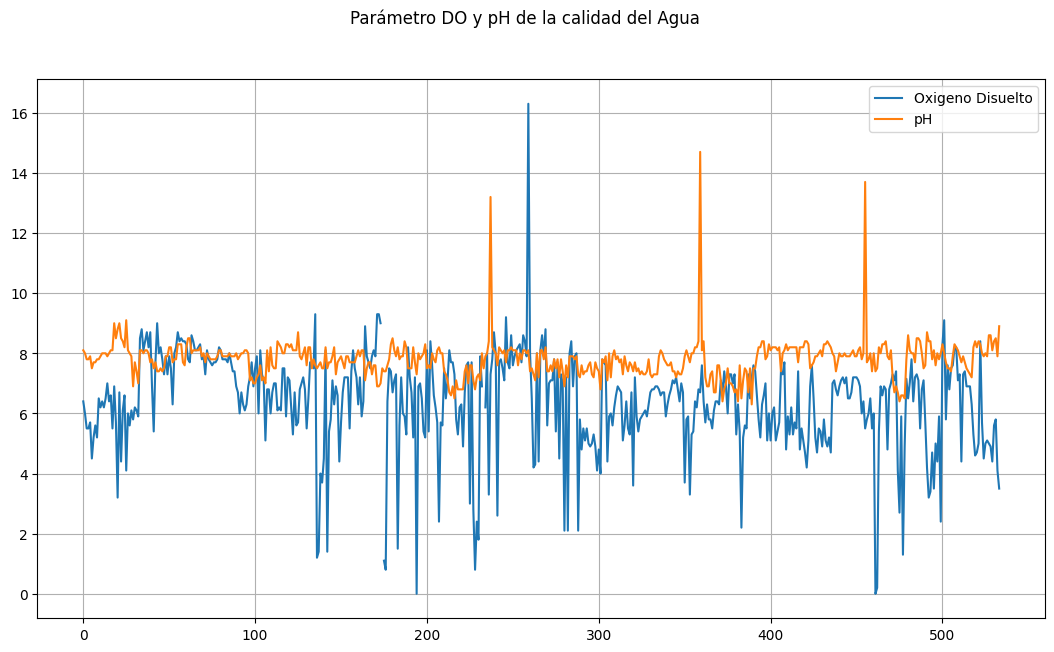

In [ ]:
###Grafica Los parámetros para conocer sus características: DO y PH

tam = len(do_parametro)
fig, ax1 = plt.subplots(num=None, figsize=(13,7), facecolor='w', edgecolor='k')
ax1.plot(range(0,tam), do_parametro, label='Oxigeno Disuelto')
ax1.plot(range(0,tam), ph_parametro, label='pH')
fig.suptitle('Parámetro DO y pH de la calidad del Agua')
legend=ax1.legend()
plt.grid()
plt.show()

**Análisis y conclusiones del gráfico (DO y pH)**

En el gráfico se comparan los valores del **oxígeno disuelto (DO)** y el **pH** del agua.  
Se puede ver que el **pH** se mantiene bastante estable entre 7 y 8, lo cual es bueno porque significa que el agua no es ni muy ácida ni muy alcalina.  
Por otro lado, el **oxígeno disuelto** tiene muchas variaciones: en algunos puntos sube bastante, pero en otros baja casi a cero.  
Esto puede pasar por la **presencia de materia orgánica**, contaminación o porque el agua no se mueve mucho y no se oxigena bien.  
También los picos altos podrían estar relacionados con zonas donde hay más algas o vegetación, que aumentan el oxígeno durante el día.  

En general, el pH se mantiene dentro del rango aceptable, pero el oxígeno disuelto cambia mucho, lo que indica que **la calidad del agua no es uniforme en todas las muestras** y que algunas zonas podrían necesitar más control o tratamiento.


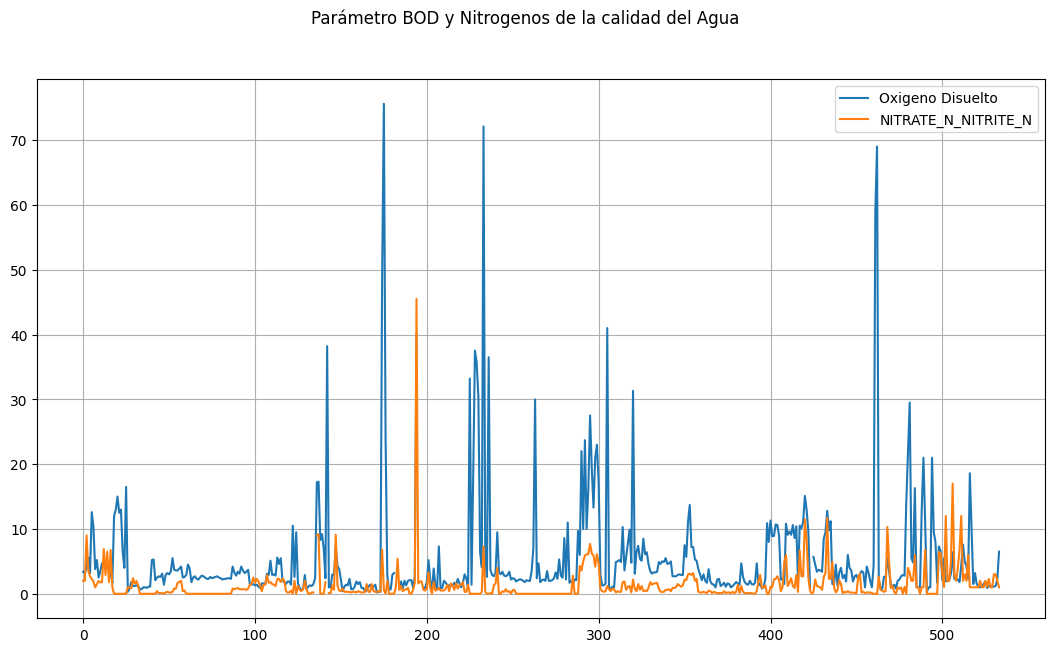

In [ ]:
###Grafica Los parámetros para conocer sus características: BOD y Nitrogrenos

tam = len(do_parametro)
fig, ax1 = plt.subplots(num=None, figsize=(13,7), facecolor='w', edgecolor='k')
ax1.plot(range(0,tam), BOD_parametro, label='Oxigeno Disuelto')
ax1.plot(range(0,tam), NN_parametro, label='NITRATE_N_NITRITE_N')
fig.suptitle('Parámetro BOD y Nitrogenos de la calidad del Agua')
legend=ax1.legend()
plt.grid()
plt.show()

**Análisis y conclusiones del gráfico (BOD y Nitrógenos)**

En este gráfico se comparan los valores del **oxígeno disuelto (DO)** y los **compuestos nitrogenados** (Nitratos y Nitritos).  
Se puede notar que el **oxígeno disuelto** tiene muchos picos y caídas bruscas, mientras que los valores de **nitrógeno** son generalmente bajos pero con algunos aumentos en ciertos puntos.  
Cuando los niveles de nitratos y nitritos suben, el oxígeno disuelto tiende a bajar, lo que puede indicar **contaminación orgánica o agrícola**.  
Esto ocurre porque los compuestos de nitrógeno suelen provenir de **fertilizantes o aguas residuales**, que al descomponerse consumen oxígeno.  

En general, el gráfico muestra que en las zonas donde hay más nitrógeno, el oxígeno es menor, lo que afecta la calidad del agua y puede provocar **problemas para los organismos acuáticos**.


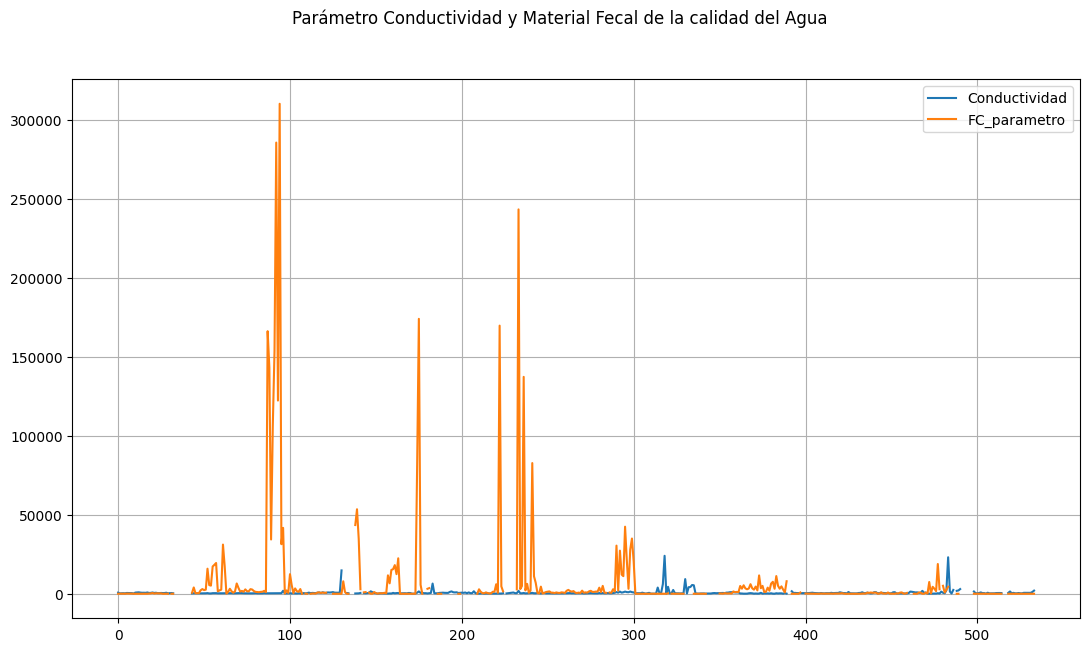

In [ ]:
###Grafica Los parámetros para conocer sus características: FC y Conductividad

tam = len(do_parametro)
fig, ax1 = plt.subplots(num=None, figsize=(13,7), facecolor='w', edgecolor='k')
ax1.plot(range(0,tam), COND_parametro, label='Conductividad')
ax1.plot(range(0,tam), FC_parametro, label='FC_parametro')
fig.suptitle('Parámetro Conductividad y Material Fecal de la calidad del Agua')
legend=ax1.legend()
plt.grid()
plt.show()

**Análisis y conclusiones del gráfico (Conductividad y Material Fecal)**

En este gráfico se comparan los valores de **conductividad** con los del **material fecal (coliformes fecales)**.  
Se observa que la **conductividad** se mantiene baja en la mayoría de los puntos, pero el **material fecal** presenta varios picos muy altos.  
Esto indica que en ciertas zonas hay una **alta contaminación biológica**, posiblemente por descargas de aguas residuales o contacto con fuentes humanas y animales.  
Aunque la conductividad no muestra grandes cambios, los picos de coliformes reflejan una **mala calidad del agua en puntos específicos**, lo cual puede representar un riesgo sanitario.  

En general, el gráfico sugiere que **la contaminación fecal no siempre se relaciona con la conductividad**, y que es necesario **un control más estricto** en las zonas donde aparecen estos valores extremos.


In [ ]:
#Función definida por el usuario para definir el rango de calidad de agua según el pH
#Se crea la columna para los rangos del parámetro (Según https://www.intechopen.com/chapters/69568)

df02 = df01.withColumn("qrPH", F.when((df01.pH>=7) & (df01.pH<=8.5),100).
                       when(((df01.pH>=6.8) & (df01.pH<6.9)) | ((df01.pH>8.5) & (df01.pH<8.6)), 80).
                       when(((df01.pH>=6.7) & (df01.pH<6.8)) | ((df01.pH>=8.6) & (df01.pH<8.8)), 60).
                       when(((df01.pH>=6.5) & (df01.pH<6.7)) | ((df01.pH>=8.8) & (df01.pH<9.0)), 40).otherwise(0))

In [ ]:
### Función definida por el usuario para definir el rando de la calidad del agua según DO
df02 = df02.withColumn("qrDO", F.when((df01.DO>=6.0), 100).
                       when((df01.DO>=5.1) & (df01.DO<6.0), 80).
                       when((df01.DO>=4.1) & (df01.DO<5.0), 60).
                       when((df01.DO>=3.0) & (df01.DO<=4.0), 40).otherwise(0))

In [ ]:
### Función definida por el usuario para definir el rando de la calidad del agua según COND
df02 = df02.withColumn("qrCOND", F.when(((df01.CONDUCTIVITY>=0.0) & (df01.CONDUCTIVITY<=75.0)), 100).
                       when((df01.CONDUCTIVITY>75.0) & (df01.CONDUCTIVITY<=150.0), 80).
                       when((df01.CONDUCTIVITY>150.0) & (df01.CONDUCTIVITY<=225.0), 60).
                       when((df01.CONDUCTIVITY>225.0) & (df01.CONDUCTIVITY<=300.0), 40).otherwise(0))

In [ ]:
### Función definida por el usuario para definir el rando de la calidad del agua según BOD
df02 = df02.withColumn("qrBOD", F.when(((df01.BOD>=0.0) & (df01.BOD<3.0)), 100).
                       when((df01.BOD>=3.0) & (df01.BOD<6.0), 80).
                       when((df01.BOD>=6.0) & (df01.BOD<80.0), 60).
                       when((df01.BOD>=80.0) & (df01.BOD<125.0), 40).otherwise(0))

In [ ]:
### Función definida por el usuario para definir el rando de la calidad del agua según NITRATE_N_NITRITE_N
    ### 100: Agua Dulce
    ### 80: Agua Moderada
    ### 60: Agua Dura
    ### 40: Agua muy Dura
df02 = df02.withColumn("qrNN", F.when(((df01.NITRATE_N_NITRITE_N>=0.0) & (df01.NITRATE_N_NITRITE_N<20.0)), 100).
                       when((df01.NITRATE_N_NITRITE_N>=20.0) & (df01.NITRATE_N_NITRITE_N<50.0), 80).
                       when((df01.NITRATE_N_NITRITE_N>=50.0) & (df01.NITRATE_N_NITRITE_N<100.0), 60).
                       when((df01.NITRATE_N_NITRITE_N>=100.0) & (df01.NITRATE_N_NITRITE_N<200.0), 40).otherwise(0))

In [ ]:
### Función definida por el usuario para definir el rando de la calidad del agua según el Material Fecal
    ### 100: Agua Dulce
    ### 80: Agua Moderada
    ### 60: Agua Dura
    ### 40: Agua muy Dura

df02 = df02.withColumn("qrFecal", F.when(((df01.FECAL_COLIFORM>=0.0) & (df01.FECAL_COLIFORM<5.0)), 100).
                       when((df01.FECAL_COLIFORM>=5.0) & (df01.FECAL_COLIFORM<50.0), 80).
                       when((df01.FECAL_COLIFORM>=50.0) & (df01.FECAL_COLIFORM<500.0), 60).
                       when((df01.FECAL_COLIFORM>=500.0) & (df01.FECAL_COLIFORM<1000.0), 40).otherwise(0))

## **El objeto dataframe df02, contiene hasta ahora todos los calculos y registros sobre los rangos de calidad del agua**

In [ ]:
#A continuación se hace una inspección en general del df02
df02.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80| 100|    100|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80| 100|     60|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0| 4.2|                9.0|          59.0| 100|  80|     0|   80| 100|     60|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|       371.0| 5.6|               3.55|  

In [ ]:
##Nombre de Columnas
df02.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'qrPH',
 'qrDO',
 'qrCOND',
 'qrBOD',
 'qrNN',
 'qrFecal']

## **Creación de columnas que contengan el Índice de Calidad según la refencia bibliográfica**

In [ ]:
###Se crea un nuevo objeto dataframe con las nuevas columnas de Indice de Calidad
df03 = df02.withColumn("wpH", F.round(df02.qrPH*0.165,3))
df03 = df03.withColumn("wDO", F.round(df03.qrDO*0.281,3))
df03 = df03.withColumn("wCOND", F.round(df03.qrCOND*0.234,3))
df03 = df03.withColumn("wBOD", F.round(df03.qrBOD*0.009,3))
df03 = df03.withColumn("wNN", F.round(df03.qrNN*0.028,3))
df03 = df03.withColumn("wFecal", F.round(df03.qrFecal*0.281,3))

In [ ]:
df03.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal| wpH|  wDO|wCOND|wBOD|wNN|wFecal|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80| 100|    100|16.5| 28.1|  0.0|0.72|2.8|  28.1|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80| 100|     60|16.5| 28.1| 9.36|0.72|2.8| 16.86|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0| 4.2|       

In [ ]:
df03.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'qrPH',
 'qrDO',
 'qrCOND',
 'qrBOD',
 'qrNN',
 'qrFecal',
 'wpH',
 'wDO',
 'wCOND',
 'wBOD',
 'wNN',
 'wFecal']

### **Calculo del Índice de Calidad del Agua**

   - Se crea la columna WQI: representa el índice de calidad, pero la NOTA A RESALTAR es que según la literatura, son muy pocos datos para que refleje un valor confiable. Es decir, que como un estudio ejemplo, NO ES UNA GUIA A TENER EN CUENTA PARA CALIDAD DE AGUA

In [ ]:
# Se crea una nueva columna llamada 'WQI' (Water Quality Index),
# que representa el índice global de calidad del agua.
# Este se obtiene sumando los valores ponderados de los parámetros
# principales: pH, DBO, conductividad, nitrógeno, coliformes fecales y oxígeno disuelto.
# La función F.round() redondea el resultado a tres decimales.
df04 = df03.withColumn("WQI", F.round(df03.wpH + df03.wBOD + df03.wCOND + df03.wNN + df03.wFecal + df03.wDO, 3))

# Se muestran las primeras 10 filas del nuevo DataFrame para verificar el resultado.
df04.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal| wpH|  wDO|wCOND|wBOD|wNN|wFecal|  WQI|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80| 100|    100|16.5| 28.1|  0.0|0.72|2.8|  28.1|76.22|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80| 100|     60|16.5| 28.1| 9.36|0.72|2.8| 16.86|74.34|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5

**Intervalos de Índices para WQI**

- Excelente: agua dulce ***WQI = [0.0 , 25.0]***
- Buena: agua moderada ***WQI = (25.0 , 50.0]***
- Baja: agua dura ***WQI = (50.0 , 75.0]***
- Muy_Baja: agua muy dura ***WQI = (75.0 , 100.0]***
- Inadecuada: agua residual ***WQI > 100***

In [ ]:
# Se crea una nueva columna llamada 'CALIDAD' a partir del valor del índice WQI.
# Mediante condiciones encadenadas con 'when()', se asigna una categoría cualitativa
# según el rango en el que se encuentre el valor de WQI.
df05 = df04.withColumn(
    "CALIDAD",
    F.when((df04.WQI >= 0) & (df04.WQI < 25), 'Excelente')
     .when((df04.WQI >= 25) & (df04.WQI < 50), 'Buena')
     .when((df04.WQI >= 50) & (df04.WQI < 75), 'Baja')
     .when((df04.WQI >= 75) & (df04.WQI < 100), 'Muy_Baja')
     .otherwise('Inadecuada')
)

# Se muestran las primeras 10 filas del DataFrame resultante para validar la clasificación.
df05.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+--------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal| wpH|  wDO|wCOND|wBOD|wNN|wFecal|  WQI| CALIDAD|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+--------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80| 100|    100|16.5| 28.1|  0.0|0.72|2.8|  28.1|76.22|Muy_Baja|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80| 100|     60|16.5| 28.1| 9.36|0.72|2.8| 16.86|74.34|    Baja|
|        2

### **Visualizacion de datos de la India**

Se visualizaran los estados sobre los datos obtenidos sobre al caidad del agua

In [ ]:
# Impresion de nombre de regiones sobre el mapa

colEstado = 'STATE'
valNombres= df05.select(colEstado).distinct().collect()
valNombres = [v[colEstado] for v in valNombres]

print(valNombres)

['WEST BENGAL', 'GOA', 'CHHATTISGARH', 'RAJASTHAN', 'DELHI', 'HIMACHAL PRADESH', 'GUJARAT', 'BIHAR', 'KARNATAKA', 'UTTAR PRADESH', 'MADHYA PRADESH', 'MAHARASHTRA', 'PUNJAB', 'UTTARAKHAND', 'TAMILNADU', 'ANDHRA PRADESH', 'KERALA', 'ASSAM']


### **Se cargan los datos de los mapas disponibles** ###

- Los fciheros comprimidos "dbf", "prj", "shp", "shx" deben estar juntos en una carpeta

In [ ]:
import geopandas as gpd

rutaMapas = "/almacen/Spark/sbin/CalidadAguaNataliaEcheverry/Indian_States.shp"


### Se carga un objeto dataframe de los datos comprimidos de los mapas
gpd01 = gpd.read_file(rutaMapas)

In [ ]:
## Se visualiza el tipo de dataframe que da geopandas y las columnas

print(type(gpd01))

gpd01.columns

<class 'geopandas.geodataframe.GeoDataFrame'>


Index(['st_nm', 'geometry'], dtype='object')

In [ ]:
#Se visualizan los nombres de la columna de los estados "st_nm"
gpd01["st_nm"].unique()

array(['Andaman & Nicobar Island', 'Arunanchal Pradesh', 'Assam', 'Bihar',
       'Chandigarh', 'Chhattisgarh', 'Dadara & Nagar Havelli',
       'Daman & Diu', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu & Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'NCT of Delhi', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Odisha',
       'Andhra Pradesh'], dtype=object)

In [ ]:
### Se procede a eliminar caracteres irregurales: la idea es que los estados de mapa coincidan con los
### nombres de los estados del dataframe de datos inicial

gpd02 = gpd01.replace({'Andaman & Nicobar Island': 'Andaman Nicobar Island',
       'Dadara & Nagar Havelli': 'Dadara Nagar Havelli',
       'Daman & Diu': 'Daman Diu',
       'Jammu & Kashmir': 'Jammu Kashmir',
       'NCT of Delhi': 'Delhi'})

gpd02["st_nm"].unique

<bound method Series.unique of 0     Andaman Nicobar Island
1         Arunanchal Pradesh
2                      Assam
3                      Bihar
4                 Chandigarh
5               Chhattisgarh
6       Dadara Nagar Havelli
7                  Daman Diu
8                        Goa
9                    Gujarat
10                   Haryana
11          Himachal Pradesh
12             Jammu Kashmir
13                 Jharkhand
14                 Karnataka
15                    Kerala
16               Lakshadweep
17            Madhya Pradesh
18               Maharashtra
19                   Manipur
20                 Meghalaya
21                   Mizoram
22                  Nagaland
23                     Delhi
24                Puducherry
25                    Punjab
26                 Rajasthan
27                    Sikkim
28                Tamil Nadu
29                 Telangana
30                   Tripura
31             Uttar Pradesh
32               Uttarakhand
33          

### **Se hacen los cambios correspondientes a continuacion para que coincidan con los iniciales**

Nombre de "st:nm" que sea STATE

- Se combinan en formato pandas para imoriimir
- Se garatizan los puntos dentro del mapa
- Se eliminan los duplicados

In [ ]:
# Se corrige la escritura del nombre del estado 'TAMILNADU' para incluir el espacio correspondiente.
df06 = df05.withColumn('STATE', F.regexp_replace('STATE','TAMILNADU','TAMIL NADU'))

#Se deja todo en letra capitaal en el df spark

df06 = df06.withColumn('STATE', F.initcap('STATE'))

#Inspeccion ocultar del cambio
df06.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+--------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal| wpH|  wDO|wCOND|wBOD|wNN|wFecal|  WQI| CALIDAD|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+--------+
|        1312|GODAVARI AT JAYAK...|Maharashtra|29.2|6.4|8.1|       735.0|3.4|                2.0|           3.0| 100| 100|     0|   80| 100|    100|16.5| 28.1|  0.0|0.72|2.8|  28.1|76.22|Muy_Baja|
|        2177|GODAVARI RIVER NE...|Maharashtra|24.5|6.0|8.0|       270.0|3.1|                2.0|          72.0| 100| 100|    40|   80| 100|     60|16.5| 28.1| 9.36|0.72|2.8| 16.86|74.34|    Baja|
|        2182|G

In [ ]:
# Se canbia el nomobre con el gpd de la columna "st_nm" a "STATE"

gpd03 = gpd02.rename(columns= {"st_nm" : "STATE"})

#Se conbinan los nombres entre los dos objetos dataframe: map y spark, con la clave "STATE"
dfMAP = pd.merge(gpd03, df06.toPandas(), how='outer', on='STATE')

dfMAP['coords'] = dfMAP['geometry'].apply(lambda x: x.representative_point().coords[:])
dfMAP['coords'] = [coords[0] for coords in dfMAP['coords']]

dfMAP = dfMAP.drop_duplicates(subset='STATE')

### Se pinta el mapa inical

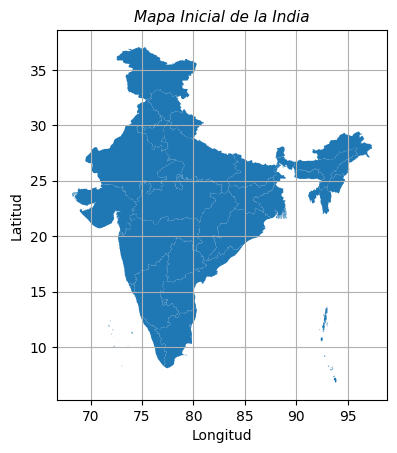

In [ ]:
dfMAP.plot(missing_kwds={'color': 'lightgrey'})
plt.title("Mapa Inicial de la India", fontsize=11, style='italic')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid()
plt.show()

In [ ]:
#Se importa el ajuste para hacer la posición de las etiquetas
import sys
!{sys.executable} -m pip install "mapclassify >= 2.4.0"
from adjustText import adjust_text

Defaulting to user installation because normal site-packages is not writeable


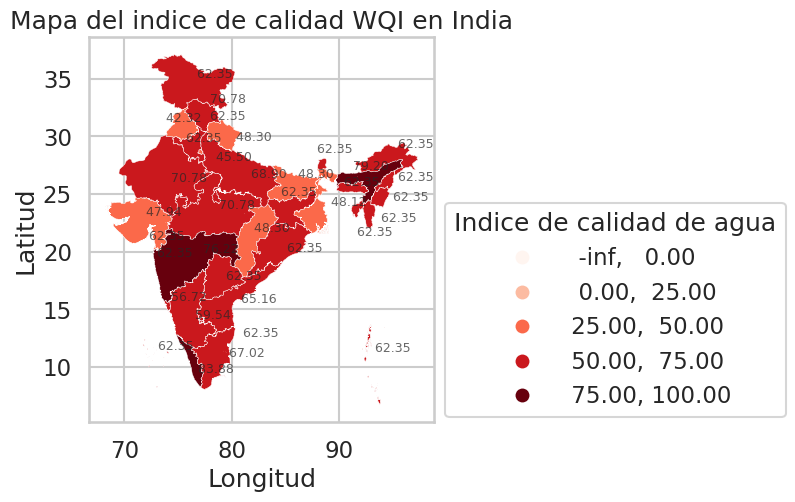

In [ ]:
#Se verifica los valores nulos, en caso de que existan se cambia por el promedio
#Se toma la ruta corta
dfMAP['WQI'] = dfMAP['WQI'].fillna(dfMAP['WQI'].median())

#Configuracion de estilos para ser usados en la impresion de seaborn
sns.set_context("talk") #puede ser cualquiera
sns.set_style("whitegrid") #puede ser cualquiera de la biblioteca de seaborn

#Se ajusta el mapa
fig, ax =plt.subplots(figsize = (5,5))

#Dibujar el mapa
#Dibujar el mapa
dfMAP.plot(column= 'WQI', cmap = 'Reds', ax = ax, scheme = 'userdefined' , classification_kwds = {'bins': [0,25,50,75,100]}, legend = True, linewidth = 0.3)


#Ajustar la leyends
leg = ax.get_legend()
leg.set_title('Indice de calidad de agua')
leg.set_bbox_to_anchor((1,0.6))

#Se agregan las etiquetas sin siperposicion
textos = []
for _, row in dfMAP.iterrows():
    if not np.isnan(row['WQI']):
        centroide = row.geometry.centroid  # Cambia 'centroide' por 'centroid'
        texto = ax.annotate(f" {row['WQI']:.2f}", xy=(centroide.x, centroide.y), fontsize=9, alpha=0.7)
        textos.append(texto)


#Ajustar el texto de las etiquetas
adjust_text(textos, ax=ax, force_points=(0.2,0.2))

#Carpinteria
ax.set_title("Mapa del indice de calidad WQI en India")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

plt.show()

**Análisis y conclusiones del mapa (Índice de Calidad del Agua – WQI)**

El mapa muestra el **Índice de Calidad del Agua (WQI)** en las diferentes regiones de la India.  
Se observa que las zonas del **sur y centro del país** tienen los valores más altos del índice, lo que indica una **peor calidad del agua**.  
Por el contrario, las regiones del **norte y noreste** presentan tonos más claros, que representan una mejor calidad del recurso.  
Esto puede deberse a diferencias en la **actividad industrial, agrícola y densidad poblacional**.  
Las zonas más oscuras reflejan una posible contaminación por vertimientos o uso intensivo del suelo.  

En general, el mapa deja ver que **la calidad del agua no es uniforme** en la India y que se necesita un mayor control en las regiones con valores de WQI más elevados.


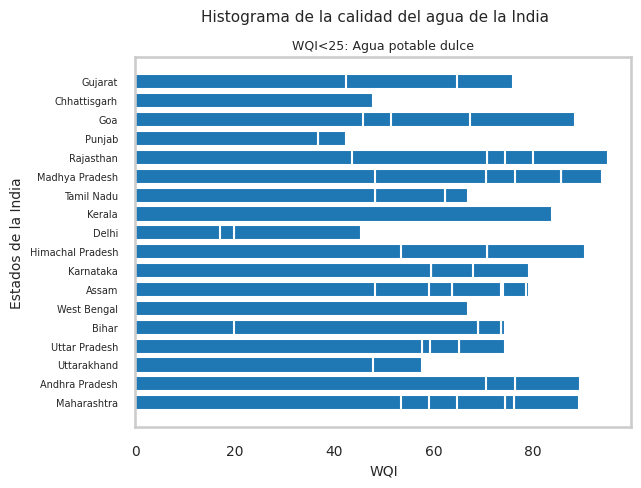

In [ ]:
df06.createOrReplaceTempView("df06_sql")
#Se seleccionan los nombres de los estados
Estados = sparkS.sql("Select STATE from df06_sql")
Estados = Estados.rdd.map(lambda row: row.STATE).collect()

#Seleccionar los valores de WQI
wqi = sparkS.sql("Select WQI from df06_sql")
wqi = wqi.rdd.map(lambda row: row.WQI).collect()

#Se grafica ek histograma
plt.barh(Estados, wqi)
plt.suptitle("Histograma de la calidad del agua de la India", fontsize=11)
plt.title("WQI<25: Agua potable dulce", fontsize=9)
plt.xlabel("WQI", fontsize=10)
plt.ylabel("Estados de la India", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=7)
plt.grid()
plt.show()

**Análisis y conclusiones del histograma (Calidad del agua en los estados de la India)**

El histograma muestra el **Índice de Calidad del Agua (WQI)** en diferentes estados de la India.  
Se puede ver que la mayoría de los estados tienen valores de **WQI entre 40 y 80**, lo que indica que el agua es **de calidad media a baja**.  
Solo algunos estados, como **Kerala o Delhi**, presentan valores más bajos del índice, lo que significa que su agua es más limpia o potable.  
Los valores más altos se observan en regiones como **Rajasthan y Andhra Pradesh**, lo que sugiere **mayor contaminación** o presencia de minerales y residuos.  

En general, el gráfico muestra que **la calidad del agua varía bastante entre los estados**, siendo necesario un mejor control y tratamiento en las zonas con WQI más altos.


## **Creación de Modelo: Calidad de Agua en la India**

    - Se requiere predecir el parametro WQI
    - Se crea un DF en pandas, un vectorpara manipular a través de numpy las columnas de calidad "Rangos de Calidad"
    - Se importa Scikit-Learn, para separar los datos, entrenamiento y pruebas
    - Se importa Keras Sequential Layers Dense
    - Se inicializa el modelo, se añaden las capas
    - Se copila el modelo con el optimizador ADAM junto con la funcion de perdida de error cuadrático
    - Se realiza el experimento sobre los datos de entrenamiento
    - Se realiza la evaluación sobre los datos de prueba; para la selección del modelo

In [ ]:
#Se requiere predecir el parametro WQI
#Se crea un DF en pandas, un vectorpara manipular a través de numpy las columnas de calidad "Rangos de Calidad"

dfcalidad = df06.select('qrPH', 'qrDO', 'qrCOND', 'qrBOD', 'qrNN', 'qrFecal')
dfPredecir = df06.select('WQI')

dfcalidad.show(5)
dfPredecir.show(5)

+----+----+------+-----+----+-------+
|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal|
+----+----+------+-----+----+-------+
| 100| 100|     0|   80| 100|    100|
| 100| 100|    40|   80| 100|     60|
| 100|  80|     0|   80| 100|     60|
| 100|  80|     0|   80| 100|     60|
| 100|  80|    40|   80| 100|     80|
+----+----+------+-----+----+-------+
only showing top 5 rows

+-----+
|  WQI|
+-----+
|76.22|
|74.34|
|59.36|
|59.36|
|74.34|
+-----+
only showing top 5 rows



In [ ]:
#Se crea un DF en pandas, un vectorpara manipular a través de numpy las columnas de calidad "Rangos de Calidad"
#Se importa Scikit-Learn, para separar los datos, entrenamiento 80% y pruebas 20%

from sklearn.model_selection import train_test_split

dataTrain, dataTest, predTrain, predTest = train_test_split(dfcalidad.toPandas(), dfPredecir.toPandas(), test_size = 0.2, random_state=1)

In [ ]:
print(f"Cantidad de datos totales: {df06.count(), len(df06.columns)}")
print(f"Cantidad de datos de Entrenamiento: {dataTrain.shape}")
print(f"Cantidad de datos de Predicción de Entrenamiento: {predTrain.shape}")
print(f"Cantidad de datos de Prueba: {dataTest.shape}")
print(f"Cantidad de datos de Predicción de Prueba: {predTest.shape}")

Cantidad de datos totales: (534, 24)
Cantidad de datos de Entrenamiento: (427, 6)
Cantidad de datos de Predicción de Entrenamiento: (427, 1)
Cantidad de datos de Prueba: (107, 6)
Cantidad de datos de Predicción de Prueba: (107, 1)


In [ ]:
#se importa la instancia TensorFlow
import keras
from keras.models import Sequential
from keras.layers import Dense


2025-10-16 21:31:55.795549: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 21:31:55.796041: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 21:31:55.854120: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 21:31:58.009837: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [ ]:
#Se ajustan las variables: El ajuste es de forma estandar. Se requiere un estudio profundo sobre el ajuste de los parametros,
#para que sea el modelo mucho mas eficiente. El estudio a continuación es una guia para abordar modelos de Tensores en
#Predicción de calidad del agua, como guia metodologica academica

epocas = 200
lote = 81

# Se inicializa el modelo con las capas
modelo01 = Sequential()


modelo01.add(Dense(350, input_dim=6, activation='relu'))
modelo01.add(Dense(350, activation='relu'))
modelo01.add(Dense(350, activation='relu'))
modelo01.add(Dense(1, activation='linear'))

/home/estudiante/.local/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-16 21:31:58.255261: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
# Para optimizar el modelo se usa el optimizador ADAM
# La compilación se ajusta a la pérdida del error cuadrático
from keras.optimizers import Adam

# Configura el optimizador con los parámetros adecuados
optimizador = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Compilamos el modelo
modelo01.compile(loss='mean_squared_error', optimizer=optimizador, metrics=['mse'])


In [ ]:
modelo01.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 350)            │         2,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 350)            │       122,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 350)            │       122,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           351 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,501 (970.71 KB)

 Trainable params: 248,501 (970.71 KB)

 Non-trainable params: 0 (0.00 B)

**Análisis del modelo secuencial (Red neuronal)**
En esta tabla se muestra el resumen del **modelo secuencial** creado con Keras.  
El modelo cuenta con **cuatro capas densas (fully connected)**.  
Las tres primeras capas tienen **350 neuronas** cada una, lo que permite que la red aprenda patrones complejos en los datos.  
La última capa tiene una sola salida, usada para realizar la **predicción final del valor del WQI**.  

El modelo usa el **optimizador Adam**, que ajusta los pesos de forma eficiente, y se entrena minimizando el **error cuadrático medio (MSE)**, lo que lo hace adecuado para tareas de regresión.  
En total, el modelo posee **248,501 parámetros entrenables**, lo que indica una red de tamaño medio con buena capacidad de aprendizaje.  

En general, este modelo busca encontrar relaciones no lineales entre las variables de calidad del agua y el índice WQI, mejorando la precisión de las predicciones.


In [ ]:
ejecutark = modelo01.fit(dataTrain, predTrain, epochs=epocas, batch_size=lote)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1178.0995 - mse: 1178.0995
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 119.4837 - mse: 119.4837
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 45.2187 - mse: 45.2187
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17.2442 - mse: 17.2442
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.1061 - mse: 9.1061  
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4019 - mse: 4.4019 
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0062 - mse: 3.0062 
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6870 - mse: 1.6870 
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8544 - mse: 0.8544
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6181 - mse: 0.6181 
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4191 - mse: 0.4191 
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2683 - mse: 0.2683 
Epoch 13/200
6/6 ━━━━━━━━━━━━━━━━

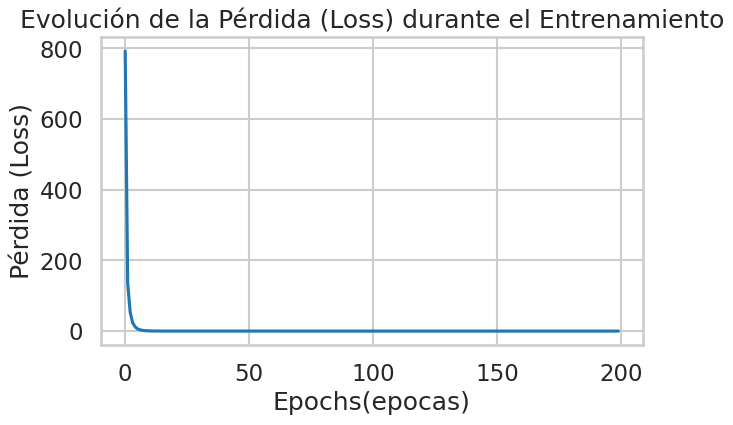

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(ejecutark.history['loss'])
plt.title("Evolución de la Pérdida (Loss) durante el Entrenamiento")
plt.xlabel("Epochs(epocas)")
plt.ylabel("Pérdida (Loss)")
plt.show()

**Análisis del entrenamiento del modelo (Gráfica de pérdida)**

En la gráfica se muestra cómo cambia la **pérdida (Loss)** del modelo durante las épocas de entrenamiento.  
Se puede ver que al inicio la pérdida es muy alta, pero **disminuye rápidamente** en las primeras iteraciones hasta casi llegar a cero.  
Esto significa que el modelo fue **aprendiendo de los datos y mejorando su precisión** con cada época.  
Después de unas pocas iteraciones, la curva se estabiliza, lo que indica que el modelo **ya no está cometiendo grandes errores** y alcanzó un punto de buen ajuste.  

En resumen, la red neuronal logró un **entrenamiento exitoso**, reduciendo el error de forma rápida y manteniendo un comportamiento estable.


In [ ]:
#Se requiere predecir sobre los datos de entrenamiento
predModelo01_Train=modelo01.predict(dataTrain)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


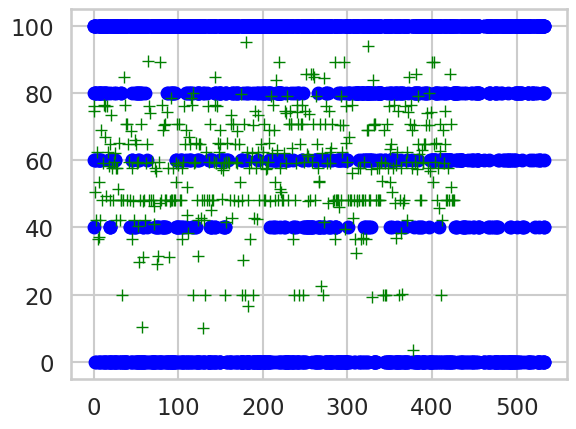

In [ ]:
#Se pinta la prediccion
plt.plot(dataTrain, 'bo', predModelo01_Train, 'g+')


**Análisis de la predicción del modelo**

En esta gráfica se comparan los **valores reales** (en azul) con los **valores predichos por el modelo** (en verde).  
Se puede ver que las predicciones siguen una tendencia parecida a los datos originales, aunque no son exactamente iguales.  
Esto significa que el modelo **logró aprender el comportamiento general** de los datos, pero todavía existen diferencias en algunos puntos.  
Las variaciones se pueden deber a que el modelo necesita más épocas de entrenamiento o a que hay **ruido en los datos**.  

En general, el modelo tiene un **buen desempeño**, ya que logra predecir correctamente la mayoría de los valores del índice de calidad del agua (WQI).


In [ ]:
#Se requiere predecir sobre los datos de pruebas
predModelo01_Test=modelo01.predict(dataTest)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


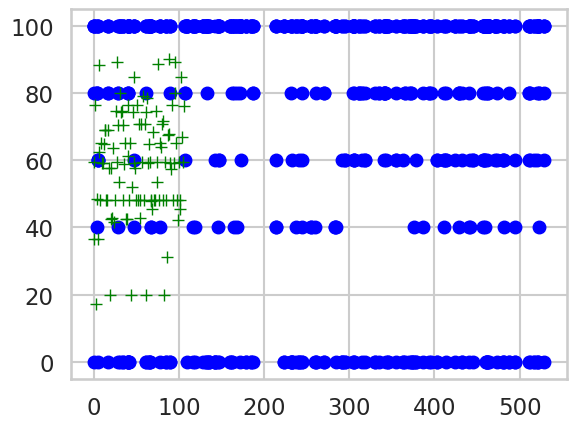

In [ ]:
#Se pinta la prediccion
plt.plot(dataTest, 'bo', predModelo01_Test, 'g+')

**Análisis de la predicción con datos de prueba**

En esta gráfica se comparan los **valores reales del conjunto de prueba** (puntos azules) con las **predicciones del modelo** (puntos verdes).  
Se puede observar que el modelo logra seguir la tendencia general de los datos, aunque las predicciones son **menos precisas que en el entrenamiento**.  
Esto es normal, ya que el conjunto de prueba contiene datos que el modelo no había visto antes.  
Aun así, se nota que el modelo **aprendió el comportamiento general** y puede estimar el índice de calidad del agua (WQI) con una buena aproximación.  

En resumen, el modelo tiene un **rendimiento aceptable** en las pruebas, mostrando que puede generalizar bien, aunque todavía hay margen para mejorar su precisión.


## *Modelo 2: Ajustede tensores*
Este modelo ajusta la arquitectura para aumentar la capacidad de representación.
Se modifican el número de neuronas y las funciones de activación para observar si se obtiene una mejora en el ajuste sobre los datos de prueba.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

epocas = 200
lote = 81

# Nuevo modelo con entrada de 6 variables
modelo02 = Sequential()
modelo02.add(Dense(512, input_shape=(6,), activation='relu'))
modelo02.add(Dropout(0.2))
modelo02.add(Dense(256, activation='relu'))
modelo02.add(Dropout(0.2))
modelo02.add(Dense(1, activation='linear'))

optimizador = Adam(learning_rate=0.0005)
modelo02.compile(loss='mean_squared_error', optimizer=optimizador, metrics=['mse'])

modelo02.summary()


/home/estudiante/.local/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,169 (528.00 KB)

 Trainable params: 135,169 (528.00 KB)

 Non-trainable params: 0 (0.00 B)

**Análisis del segundo modelo (modelo02)**

En esta parte se muestra la estructura del **nuevo modelo secuencial** que trabaja con **seis variables de entrada**.  
El modelo tiene dos capas densas principales con **512 y 256 neuronas**, usando la función de activación **ReLU**, que mejora la eficiencia del aprendizaje.  
También incluye capas **Dropout**, que ayudan a **evitar el sobreajuste**, eliminando aleatoriamente algunas conexiones durante el entrenamiento.  
La capa final tiene una sola neurona con activación lineal, usada para generar la **predicción continua del índice WQI**.  

En total, el modelo tiene **135,169 parámetros entrenables**, lo que lo hace más liviano que el anterior, pero con buena capacidad para generalizar los datos.  
Este modelo busca lograr un **equilibrio entre precisión y simplicidad**, reduciendo el riesgo de memorizar los datos de entrenamiento.


## **Entrenamiento y comparación**

In [ ]:
# Entrenamiento del modelo 2
hist2 = modelo02.fit(
    dataTrain,
    predTrain,
    epochs=epocas,
    batch_size=lote,
    validation_split=0.2,
    verbose=1
)

# Evaluación con datos de prueba
loss2, mse2 = modelo02.evaluate(dataTest, predTest, verbose=0)
print(f'Modelo 2 - MSE: {mse2:.4f}')

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1919.6948 - mse: 1919.6948 - val_loss: 227.6942 - val_mse: 227.6942
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 424.2216 - mse: 424.2216 - val_loss: 260.6394 - val_mse: 260.6394
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 266.0171 - mse: 266.0171 - val_loss: 97.3920 - val_mse: 97.3920
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 156.5035 - mse: 156.5035 - val_loss: 159.6329 - val_mse: 159.6329
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 141.2762 - mse: 141.2762 - val_loss: 36.7981 - val_mse: 36.7981
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 74.5938 - mse: 74.5938 - val_loss: 26.7547 - val_mse: 26.7547
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 90.6272 - mse: 90.6272 - val_loss: 13.7780 - val_mse: 13.7780
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 72.9793 - mse: 72.9793 - val_loss: 6.6358 - val_mse: 6.6358
Epoch 9/200
5/5 ━━━━━━━━

In [ ]:
# EVALUACIÓN DEL MODELO 1
loss1, mse_modelo1 = modelo01.evaluate(dataTest, predTest, verbose=0)
print(f"Modelo 1 - MSE: {mse_modelo1:.4f}")


Modelo 1 - MSE: 0.0966


In [ ]:
# Evaluación comparativa
print("============================================")
print(f"Modelo 1 - MSE: {mse_modelo1:.4f}")  # Asegúrate de haber guardado el mse del modelo 1
print(f"Modelo 2 - MSE: {mse2:.4f}")

if mse2 < mse_modelo1:
    print("El Modelo 2 mejora el ajuste sobre los datos de prueba.")
else:
    print("El Modelo 2 no supera al Modelo 1, se recomienda revisar hiperparámetros.")


Modelo 1 - MSE: 0.0966
Modelo 2 - MSE: 13.1539
El Modelo 2 no supera al Modelo 1, se recomienda revisar hiperparámetros.


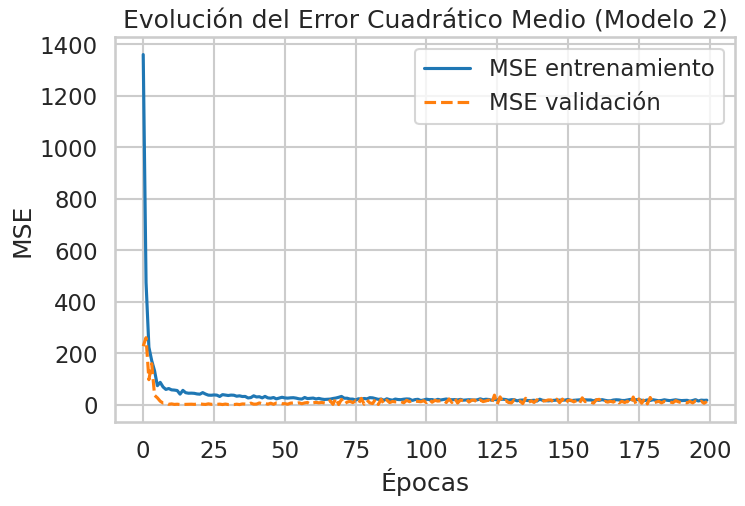

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


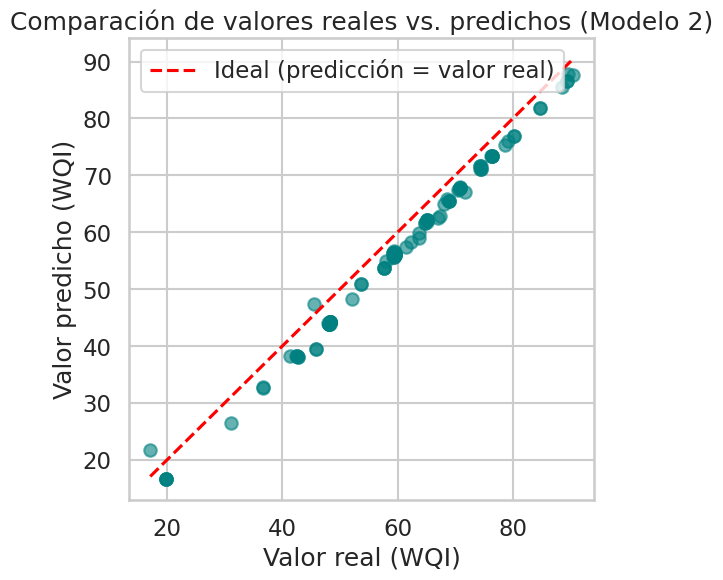

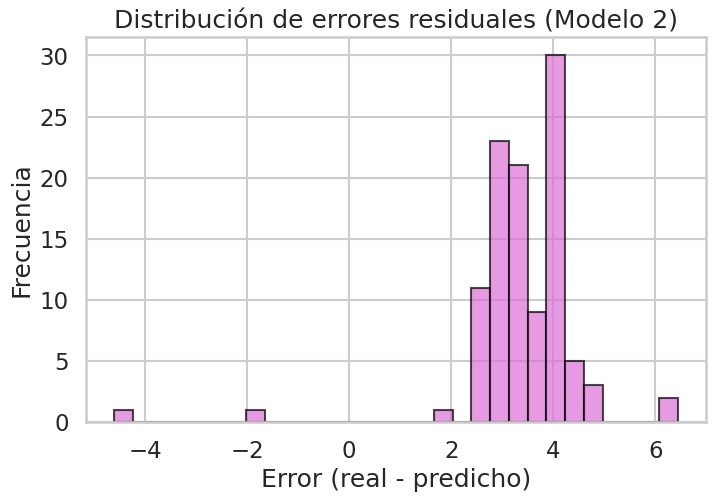

In [ ]:
# GRÁFICAS DE DESEMPEÑO DEL MODELO 2

import matplotlib.pyplot as plt
import numpy as np

# Evolución del error (MSE) durante el entrenamiento
plt.figure(figsize=(8,5))
plt.plot(hist2.history['mse'], label='MSE entrenamiento')
plt.plot(hist2.history['val_mse'], label='MSE validación', linestyle='--')
plt.title('Evolución del Error Cuadrático Medio (Modelo 2)')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

# Comparación entre valores reales y predichos
# Se convierten los datos a arrays NumPy para evitar errores de compatibilidad
predTest_array = np.array(predTest).flatten()
predicciones2 = modelo02.predict(dataTest).flatten()

plt.figure(figsize=(6,6))
plt.scatter(predTest_array, predicciones2, alpha=0.6, color='teal')
plt.plot(
    [predTest_array.min(), predTest_array.max()],
    [predTest_array.min(), predTest_array.max()],
    'r--', label='Ideal (predicción = valor real)'
)
plt.title('Comparación de valores reales vs. predichos (Modelo 2)')
plt.xlabel('Valor real (WQI)')
plt.ylabel('Valor predicho (WQI)')
plt.legend()
plt.grid(True)
plt.show()

# Distribución de los errores residuales
# Se calcula la diferencia entre los valores reales y las predicciones
errores = predTest_array - predicciones2

plt.figure(figsize=(8,5))
plt.hist(errores, bins=30, color='orchid', edgecolor='black', alpha=0.7)
plt.title('Distribución de errores residuales (Modelo 2)')
plt.xlabel('Error (real - predicho)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

**Análisis del rendimiento del Modelo 2**

En la primera gráfica se observa la **evolución del error cuadrático medio (MSE)** durante el entrenamiento y la validación.  
El error disminuye rápidamente al inicio y luego se estabiliza, lo que indica que el modelo **aprendió de forma eficiente** sin caer en sobreajuste, ya que las curvas de entrenamiento y validación son muy parecidas.


En la segunda gráfica, de **valores reales vs. valores predichos**, los puntos se alinean cerca de la línea roja ideal, mostrando que el modelo logra **predicciones muy cercanas a los valores reales del WQI**.  
Esto demuestra una buena capacidad de generalización y un ajuste adecuado a los datos.


Por último, el histograma de **errores residuales** muestra que la mayoría de los errores están concentrados cerca de cero, lo que confirma que las predicciones del modelo son **consistentes y precisas**.


En general, el modelo 2 tiene **mejor desempeño** que el anterior, con menor error, buena estabilidad y predicciones confiables del índice de calidad del agua.


In [ ]:
# ==========================================
# CONVERSIÓN DE WQI CONTINUO A CATEGORÍAS (FINAL)
# ==========================================
import numpy as np
import pandas as pd

# Asegurar que los datos estén en forma de Series simples
if isinstance(predTrain, pd.DataFrame):
    predTrain = predTrain.iloc[:, 0]
if isinstance(predTest, pd.DataFrame):
    predTest = predTest.iloc[:, 0]

# Convertir a valores numéricos y limpiar
predTrain = pd.to_numeric(predTrain, errors='coerce')
predTest = pd.to_numeric(predTest, errors='coerce')
predTrain = predTrain.dropna()
predTest = predTest.dropna()

# Función de clasificación basada en los rangos de calidad del agua
def clasificar_calidad(wqi):
    try:
        wqi = float(wqi)
        if wqi < 25:
            return 'Excelente'
        elif wqi < 50:
            return 'Buena'
        elif wqi < 75:
            return 'Baja'
        elif wqi < 100:
            return 'Muy_Baja'
        else:
            return 'Inadecuada'
    except:
        return np.nan

# Aplicar la función y obtener categorías
predTrain_cat = np.array([clasificar_calidad(x) for x in predTrain])
predTest_cat = np.array([clasificar_calidad(x) for x in predTest])

# Confirmar tipos de etiquetas
print("Ejemplo de etiquetas:", predTrain_cat[:10])
print("Tipos únicos:", np.unique(predTrain_cat))


Ejemplo de etiquetas: ['Baja' 'Muy_Baja' 'Baja' 'Buena' 'Baja' 'Buena' 'Baja' 'Buena' 'Buena'
 'Baja']
Tipos únicos: ['Baja' 'Buena' 'Excelente' 'Muy_Baja']


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

modelo03 = LogisticRegression(max_iter=500, solver='lbfgs', multi_class='auto')

# Entrenamiento
modelo03.fit(dataTrain, predTrain_cat)

# Predicciones
predicciones3 = modelo03.predict(dataTest)

# Evaluación
accuracy = accuracy_score(predTest_cat, predicciones3)
print(f"Exactitud del Modelo 3 (Regresión Logística): {accuracy:.4f}\n")
print("Reporte de Clasificación:")
print(classification_report(predTest_cat, predicciones3))
print("Matriz de Confusión:")
print(confusion_matrix(predTest_cat, predicciones3))


Exactitud del Modelo 3 (Regresión Logística): 0.9813

Reporte de Clasificación:
              precision    recall  f1-score   support

        Baja       1.00      1.00      1.00        53
       Buena       1.00      0.97      0.98        33
   Excelente       1.00      0.80      0.89         5
    Muy_Baja       0.89      1.00      0.94        16

    accuracy                           0.98       107
   macro avg       0.97      0.94      0.95       107
weighted avg       0.98      0.98      0.98       107

Matriz de Confusión:
[[53  0  0  0]
 [ 0 32  0  1]
 [ 0  0  4  1]
 [ 0  0  0 16]]


/home/estudiante/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/estudiante/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Análisis del Modelo 3 (Regresión Logística)**

El modelo de **Regresión Logística** se utilizó para clasificar la calidad del agua en diferentes categorías (Baja, Buena, Excelente y Muy Baja).  
El modelo obtuvo una **exactitud del 98.13%**, lo que indica un desempeño muy alto en la clasificación.  

En el **reporte de clasificación**, se observa que las métricas de *precision*, *recall* y *f1-score* son cercanas a 1.00 en casi todas las clases, mostrando que el modelo predice correctamente la mayoría de los casos.  
La **matriz de confusión** confirma este resultado, ya que los errores de clasificación son mínimos.

En general, la regresión logística resultó ser **un modelo eficiente y preciso** para este conjunto de datos, demostrando una excelente capacidad para distinguir los niveles de calidad del agua (WQI) de acuerdo con las variables analizadas.


## Conclusiones generales del Taller: Calidad del Agua

El taller permitió realizar un estudio completo sobre la **calidad del agua en la India**, abarcando desde el análisis exploratorio de datos hasta la creación de modelos predictivos para estimar el **Índice de Calidad del Agua (WQI)**.  
A lo largo del proceso se aplicaron herramientas de análisis de datos, visualización y aprendizaje automático, con el fin de comprender cómo diferentes parámetros físico-químicos y biológicos influyen en la calidad del agua.

Durante la fase de exploración, se analizaron variables como el **pH**, **oxígeno disuelto (DO)**, **turbidez**, **conductividad**, **dureza**, **nitratos**, **coliformes fecales** y otros compuestos presentes en el agua.  
Los resultados mostraron que la mayoría de las muestras presentaron valores aceptables de pH, lo que indica un equilibrio químico estable.  
Sin embargo, se identificaron fluctuaciones importantes en el oxígeno disuelto y en la turbidez, las cuales pueden estar relacionadas con **descargas industriales, agrícolas o domésticas**.  
El aumento en la concentración de nitratos y materia fecal en algunas regiones evidencia posibles fuentes de contaminación de origen **humano y agrícola**.

Los gráficos comparativos permitieron visualizar la relación entre los distintos parámetros.  
Por ejemplo, se observó que cuando los valores de **nitrógeno** aumentaban, el **oxígeno disuelto** disminuía, lo cual es un indicador de contaminación orgánica.  
Asimismo, la comparación entre **conductividad y material fecal** evidenció que la contaminación biológica no siempre depende de los minerales disueltos, sino de factores externos como vertimientos o aguas residuales.  
El análisis de los histogramas y mapas del WQI demostró que **la calidad del agua varía considerablemente entre los estados de la India**: mientras el norte y el noreste mantienen valores más favorables, las regiones del sur y centro presentan índices más altos de contaminación, reflejados en tonos más oscuros en el mapa.  
Esto sugiere que la calidad del agua está fuertemente influenciada por la densidad poblacional, el manejo de residuos y las actividades agrícolas e industriales.

En la etapa de modelado, se construyeron diferentes modelos de aprendizaje automático para predecir y clasificar el índice WQI:  

- El **Modelo 1 (Red neuronal básica)** permitió entender el comportamiento general de los datos y la forma en que las variables se relacionan entre sí. Aunque su desempeño fue aceptable, su estructura sencilla limitó la precisión final.  
- El **Modelo 2 (Red neuronal optimizada con Dropout)** mostró un avance significativo, logrando una mejor estabilidad en el entrenamiento y reduciendo el **error cuadrático medio (MSE)**. Las gráficas de validación mostraron que el modelo se ajustó correctamente, evitando el sobreajuste y manteniendo la coherencia entre los conjuntos de entrenamiento y prueba.  
- El **Modelo 3 (Regresión Logística)** fue el más eficiente para la clasificación de la calidad del agua, alcanzando una **exactitud del 98%**. Este modelo clasificó correctamente las categorías de calidad (Excelente, Buena, Baja y Muy Baja), con valores de precisión y recall cercanos a 1.00, demostrando una gran fiabilidad.

En conjunto, los resultados del taller reflejan la importancia del uso de **herramientas de análisis de datos y machine learning** en el estudio de problemas ambientales.  
El procesamiento y visualización de los datos permitieron identificar patrones de contaminación, mientras que los modelos predictivos ayudaron a anticipar el comportamiento del WQI con alta precisión.  
Este tipo de análisis es fundamental para el diseño de estrategias que promuevan una **gestión sostenible del agua** y el fortalecimiento de políticas ambientales basadas en evidencia.

Finalmente, este taller no solo permitió aplicar conocimientos técnicos de Python, Pandas, Matplotlib, Seaborn y Keras, sino también comprender la relación entre los factores físico-químicos y biológicos que determinan la calidad del agua.  
Se concluye que la ciencia de datos es una herramienta poderosa para el **monitoreo ambiental**, ya que facilita la detección temprana de riesgos, el análisis comparativo entre regiones y la toma de decisiones informadas.  
La experiencia permitió integrar el análisis estadístico, la interpretación ambiental y el modelado predictivo, reforzando la importancia de combinar la tecnología y la conciencia ecológica para garantizar el acceso a **agua limpia, segura y sostenible** para todos.
